In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

#metrics
import sklearn.metrics as metrics

#hiperparameters
from sklearn.model_selection import GridSearchCV

In [2]:
from catboost import CatBoostClassifier

## Load clean data

In [3]:
df = pd.read_csv('./EDA/clean_train_test_v1.csv')
df.head(1)

,mou,totmrc,da,vceovr,datovr,roam,change_mou,change_rev,drop_vce,blck_vce,...,HHstatin_C,HHstatin_G,HHstatin_H,HHstatin_I,ethnic_H,ethnic_N,ethnic_S,ethnic_U,ethnic_other,dualband_U
0,219.25,22.5,0.2475,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.666667,...,1,0,0,0,0,1,0,0,0,0


In [4]:
df_id_customer_train = df['Customer_ID']
#df_id_customer_predicr = df_predecir2['Customer_ID']

del(df['Customer_ID'])
#del(df_predecir2['Customer_ID'])

## I do a RandomForest to see which variables are more correlated

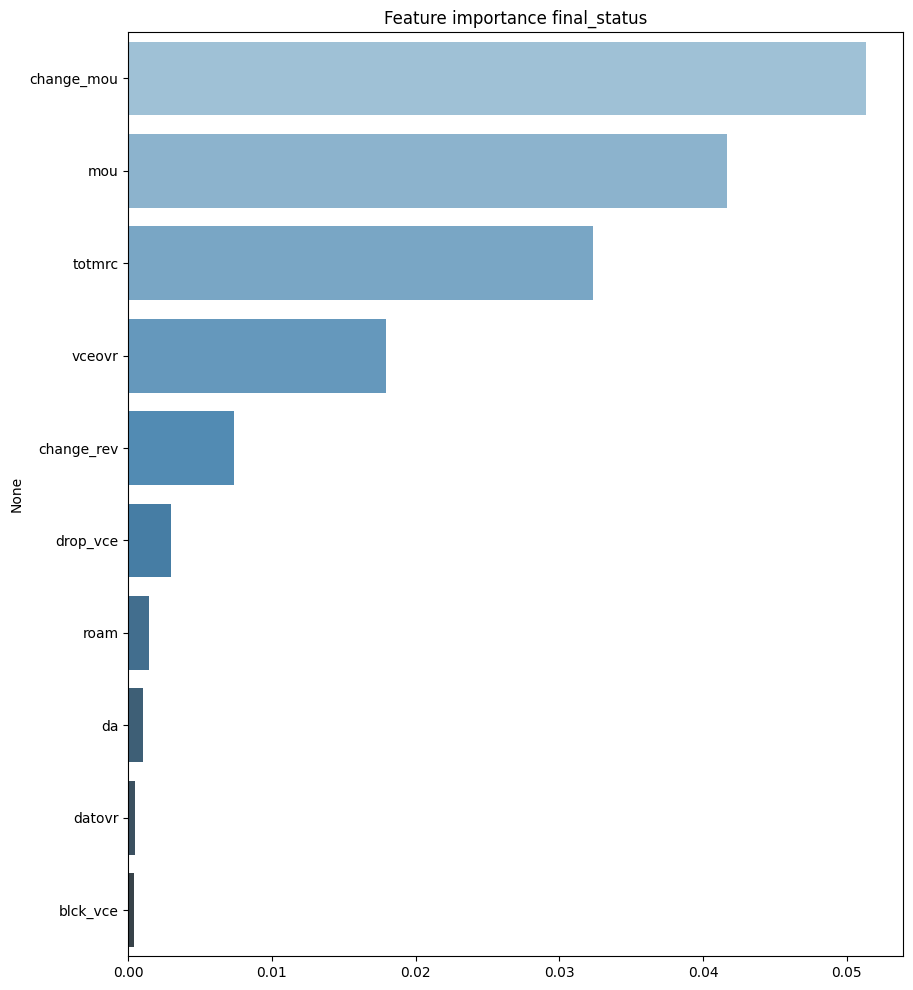

In [5]:
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

x, y = df.drop('churn',axis=1), df['churn']
# entrena un RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plotea las 10 mejores Features importances
features = clf.feature_importances_[:10]
columnas = x.columns[:10]
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance {}".format('final_status'))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

## Split X-y

In [6]:
# se guarda la target como y y las features como X
y = df['churn']
X = df.drop('churn', axis=1)

# se guarda un 30% de datos para el test y un 70% para el train con train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Distribution of Target

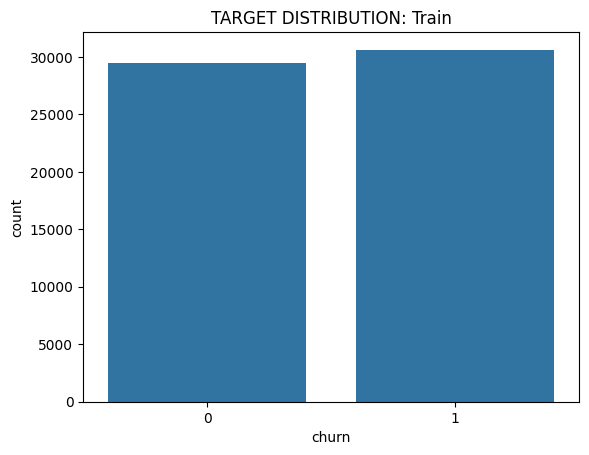

In [7]:
sns.countplot(x=y_train)
plt.title('TARGET DISTRIBUTION: Train')
plt.show()

In [8]:
# I´m going to standarize the variables with StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   
X_test = scaler.transform(X_test)

## TRAIN -VALIDA

### Model Tournament

In [9]:
def medicion(y_t, y_p):
  """Print the  ROC and the AUC curve"""

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_t, y_p)
  roc_auc = metrics.auc(fpr, tpr)

  # para añadir el gráfico
  # method I: plt
  import matplotlib.pyplot as plt
  plt.figure(figsize=(8, 6))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
  return roc_auc

In [10]:
def entrenar(Xtrain, Xtest, ytrain, ytest):
  """entrena 6 módelos.
      imprime la curva roc de cada módelo junto al valor AUC
      devuelve un dataframe con los valores de AUC redondeados a 5 decimales para cada módelo"""

  # creamos la lista de auc vacía
  lista_aucs = []

  # Support Vector Machine
  print('Support Vector Machine')
  svclassifier = SVC(max_iter=20)

  svclassifier.fit(Xtrain, ytrain)
  y_pred = svclassifier.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('SVC', round(roc_auc, 5)))

  # Regresión logística
  print('Regresión logística')
  lr = LogisticRegression(max_iter=40)

  lr.fit(Xtrain, ytrain)
  y_pred = lr.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('regresión logística', round(roc_auc, 5)))

  # RidgeClassifier
  print('RidgeClassifier')
  rc = RidgeClassifier(max_iter=40)

  rc.fit(Xtrain, ytrain)
  y_pred = rc.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('RidgeClassifier', round(roc_auc, 5)))

  # Decision tree classsifier
  print('Decision tree classsifier')
  dt_base = DecisionTreeClassifier(random_state=42)

  dt_base.fit(Xtrain, ytrain)
  y_pred = dt_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('decision tree classifier', round(roc_auc, 5)))

  # Random forest
  print('Random forest')
  rf_base = RandomForestClassifier(random_state=42)

  rf_base.fit(Xtrain, ytrain)
  y_pred = rf_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('random forest', round(roc_auc, 5)))

  # Gradient boosting
  print('Gradient boosting')
  gbc_base = GradientBoostingClassifier(random_state=42)

  gbc_base.fit(Xtrain, ytrain)
  y_pred = gbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('gradient boosting', round(roc_auc, 5)))

  # XGBClassifier
  print('XGBClassifier')
  xgbc_base = XGBClassifier(random_state=42)

  xgbc_base.fit(Xtrain, ytrain)
  y_pred = xgbc_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('XGB classifier', round(roc_auc, 5)))

  # CatBoostClassifier
  print('CatBoostClassifier')
  cat_base = CatBoostClassifier(verbose=False, random_state=42)

  cat_base.fit(Xtrain, ytrain)
  y_pred = cat_base.predict(Xtest)

  roc_auc = medicion(ytest, y_pred)
  lista_aucs.append(('CatBoost Classifier', round(roc_auc, 5)))

  df_aucs = pd.DataFrame(lista_aucs, columns=['modelos', 'AUC'])
  df_aucs = df_aucs.set_index('modelos')

  return df_aucs

Support Vector Machine


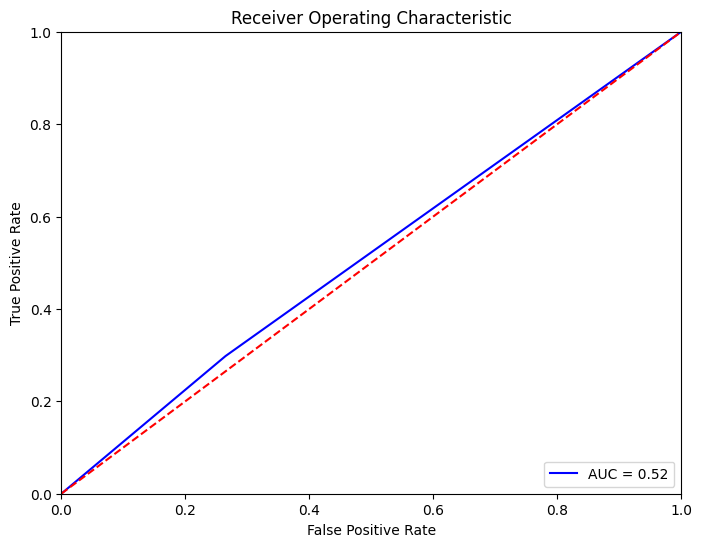

Regresión logística


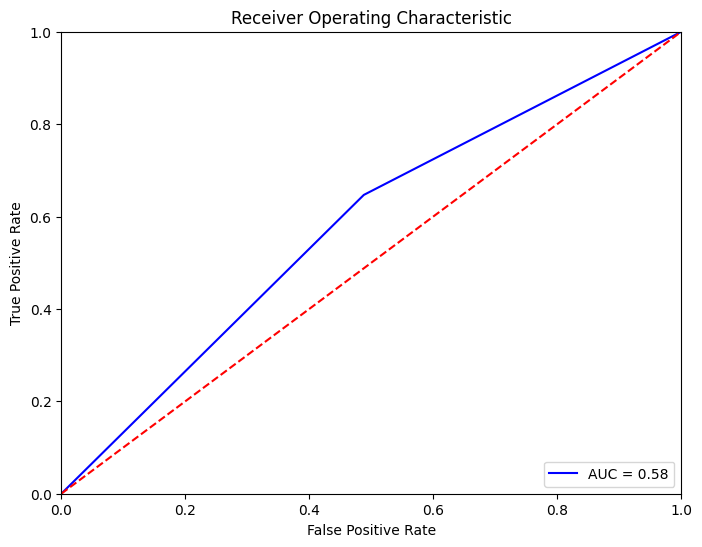

RidgeClassifier


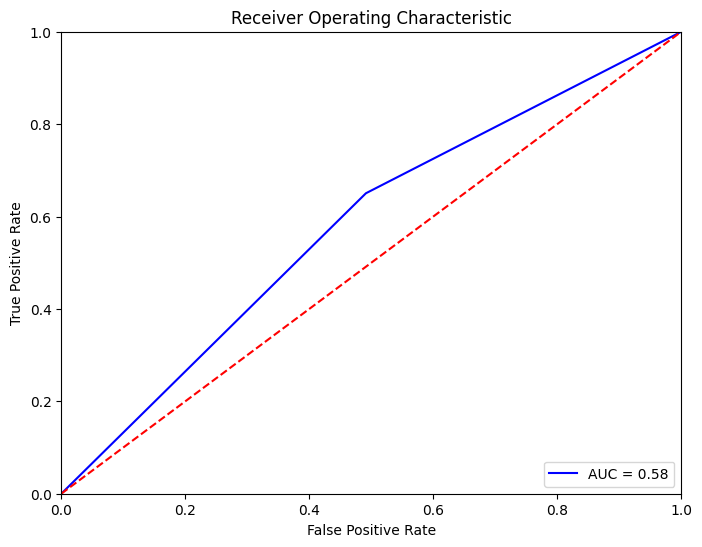

Decision tree classsifier


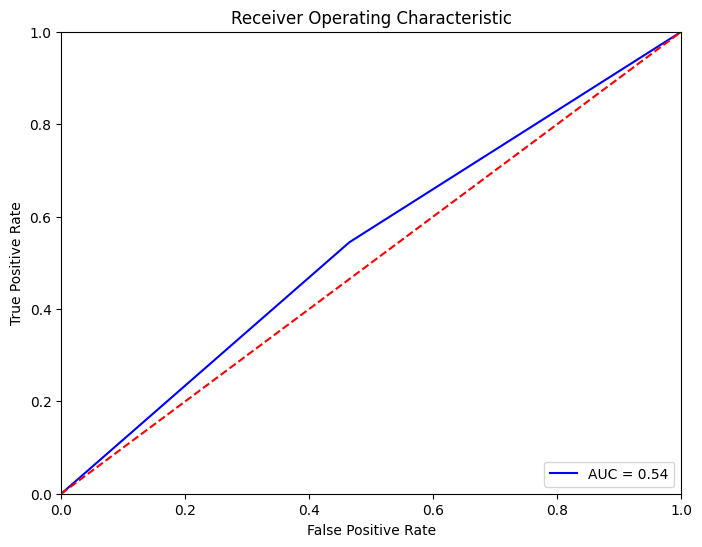

Random forest


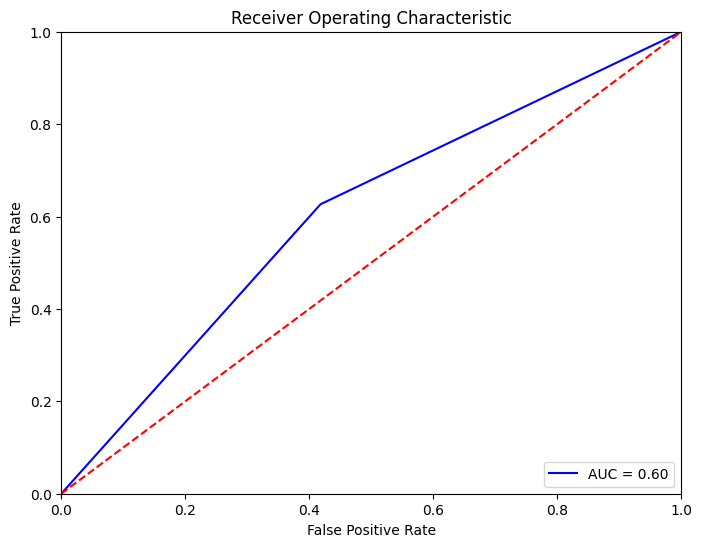

Gradient boosting


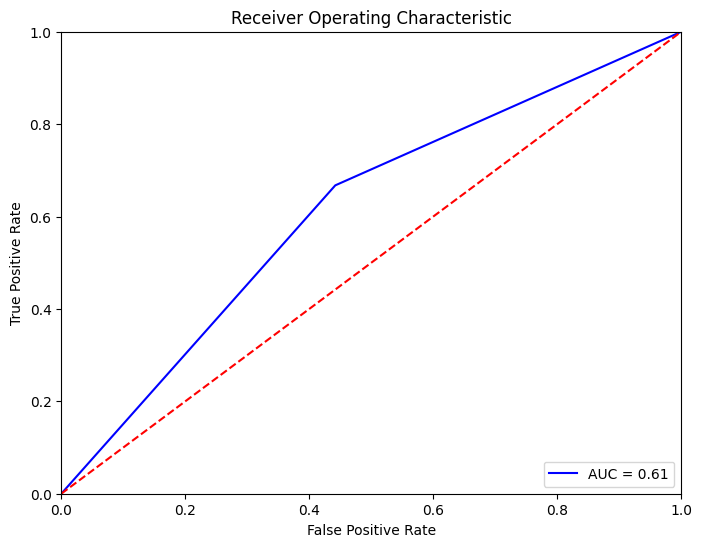

XGBClassifier


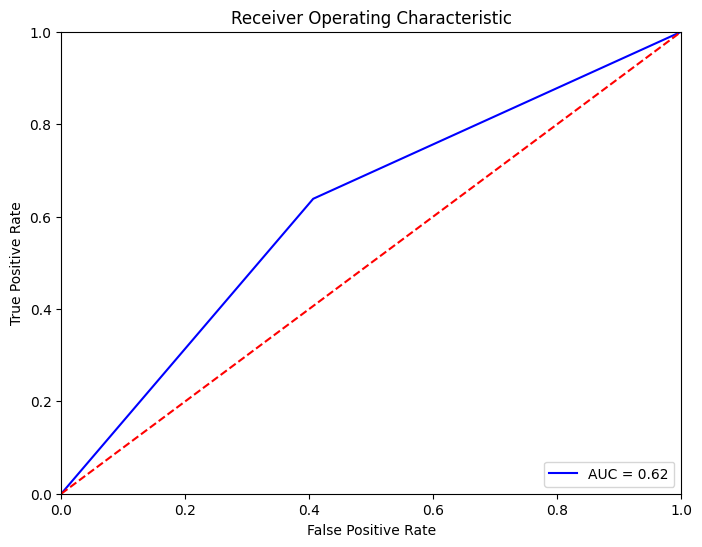

CatBoostClassifier


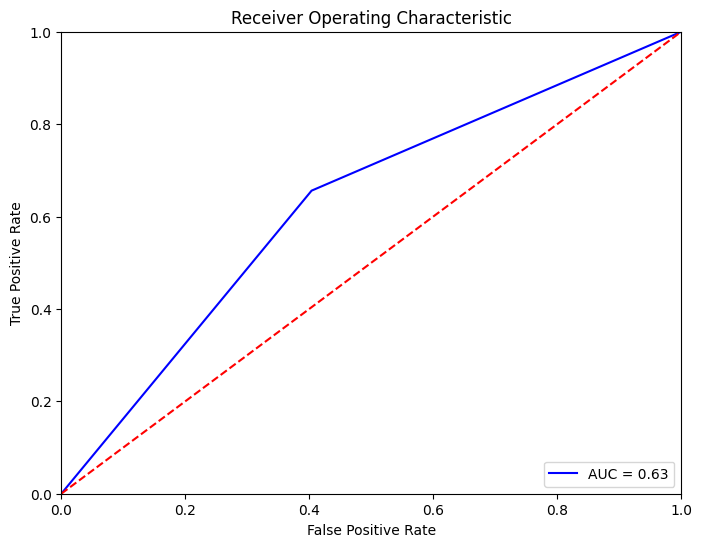

In [11]:
aucs = entrenar(X_train, X_test, y_train, y_test)

In [12]:
aucs

,AUC
modelos,
SVC,0.51653
regresión logística,0.57941
RidgeClassifier,0.57949
decision tree classifier,0.53980
random forest,0.60420
gradient boosting,0.61276
XGB classifier,0.61604
CatBoost Classifier,0.62613


In [13]:
model = CatBoostClassifier()

## Hiperparameters

In [89]:
parameters = {
    'iterations': [100, 200],
    'learning_rate':  np.linspace(0.01, 0.3, 10),
    'depth': [4, 6, 8, 10]
              }

In [90]:
modelo_grid = GridSearchCV(model,
                        parameters,
                        cv=2,
                        verbose=True)

modelo_grid.fit(X_train, y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits
0:	learn: 0.6928675	total: 8.36ms	remaining: 827ms
1:	learn: 0.6926160	total: 18.9ms	remaining: 926ms
2:	learn: 0.6923069	total: 36.8ms	remaining: 1.19s
3:	learn: 0.6919693	total: 53.3ms	remaining: 1.28s
4:	learn: 0.6916613	total: 72.3ms	remaining: 1.37s
5:	learn: 0.6913235	total: 90.1ms	remaining: 1.41s
6:	learn: 0.6909977	total: 105ms	remaining: 1.4s
7:	learn: 0.6907093	total: 122ms	remaining: 1.4s
8:	learn: 0.6904036	total: 133ms	remaining: 1.35s
9:	learn: 0.6901096	total: 141ms	remaining: 1.27s
10:	learn: 0.6898403	total: 148ms	remaining: 1.2s
11:	learn: 0.6895479	total: 155ms	remaining: 1.14s
12:	learn: 0.6892737	total: 171ms	remaining: 1.14s
13:	learn: 0.6889939	total: 185ms	remaining: 1.14s
14:	learn: 0.6887251	total: 200ms	remaining: 1.14s
15:	learn: 0.6884497	total: 207ms	remaining: 1.09s
16:	learn: 0.6881923	total: 218ms	remaining: 1.06s
17:	learn: 0.6879392	total: 228ms	remaining: 1.04s
18:	learn: 0.6877194	total:

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd644759de0>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 200],
                         'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ])},
             verbose=True)

In [91]:
#print best parameters
modelo_grid.best_params_

{'depth': 4, 'iterations': 200, 'learning_rate': 0.20333333333333334}

## Final Model

In [92]:
model = CatBoostClassifier(depth= 4, iterations= 200, learning_rate=0.203)

In [93]:
model.fit(X_train, y_train) # entrena mi modelo elegido con los datos de Train
y_pred_test = model.predict(X_test)

0:	learn: 0.6877938	total: 13.1ms	remaining: 2.61s
1:	learn: 0.6831980	total: 24.7ms	remaining: 2.45s
2:	learn: 0.6795752	total: 35.9ms	remaining: 2.36s
3:	learn: 0.6760408	total: 43.6ms	remaining: 2.13s
4:	learn: 0.6736787	total: 54ms	remaining: 2.11s
5:	learn: 0.6712572	total: 67.7ms	remaining: 2.19s
6:	learn: 0.6698535	total: 74.7ms	remaining: 2.06s
7:	learn: 0.6684431	total: 86.5ms	remaining: 2.07s
8:	learn: 0.6672618	total: 93.5ms	remaining: 1.98s
9:	learn: 0.6658848	total: 104ms	remaining: 1.98s
10:	learn: 0.6646875	total: 116ms	remaining: 1.99s
11:	learn: 0.6634857	total: 138ms	remaining: 2.16s
12:	learn: 0.6625585	total: 153ms	remaining: 2.2s
13:	learn: 0.6617623	total: 167ms	remaining: 2.21s
14:	learn: 0.6611806	total: 182ms	remaining: 2.24s
15:	learn: 0.6605262	total: 198ms	remaining: 2.28s
16:	learn: 0.6600090	total: 210ms	remaining: 2.27s
17:	learn: 0.6592649	total: 223ms	remaining: 2.26s
18:	learn: 0.6585854	total: 240ms	remaining: 2.29s
19:	learn: 0.6579886	total: 255ms	r

In [94]:
model.predict_proba(X_test)[:,1]

array([0.47910321, 0.56226441, 0.61591411, ..., 0.44941725, 0.52538657,
       0.65126133])

### I created a dataframe with my results of test

In [95]:
df_values = pd.DataFrame()

In [96]:
df_values['target_real']=y_test
df_values['prediccion']=y_pred_test
df_values['prediccion_proba']=model.predict_proba(X_test)[:,1]

In [97]:
df_values

,target_real,prediccion,prediccion_proba
15277,1,0,0.479103
84492,0,1,0.562264
59249,0,1,0.615914
8748,0,1,0.565656
70349,0,0,0.369706
...,...,...,...
63901,0,1,0.546618
13650,0,1,0.505191
45171,0,0,0.449417
48103,1,1,0.525387


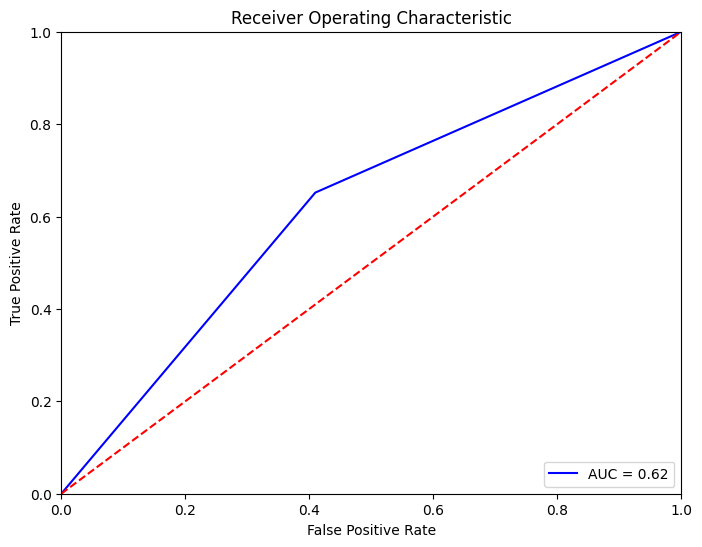

0.621032330570769


In [98]:
roc_auc = medicion(y_test, y_pred_test)
print(roc_auc)

## Test

In [99]:
y_train_pred = model.predict(X_train)                        
y_test_pred = model.predict(X_test)

In [100]:
y_train_pred_proba = model.predict_proba(X_train)[:, 1]      
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

In [101]:
from sklearn.metrics import roc_auc_score

In [102]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_test = roc_auc_score(y_test, y_test_pred_proba)   

In [103]:
print('AUC Train:', round(auc_train,4))
print('AUC Test:', round(auc_test,4))

AUC Train: 0.7173
AUC Test: 0.6718


### ROC curve

In [104]:
from sklearn.metrics import roc_curve

In [105]:
# metrics for ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

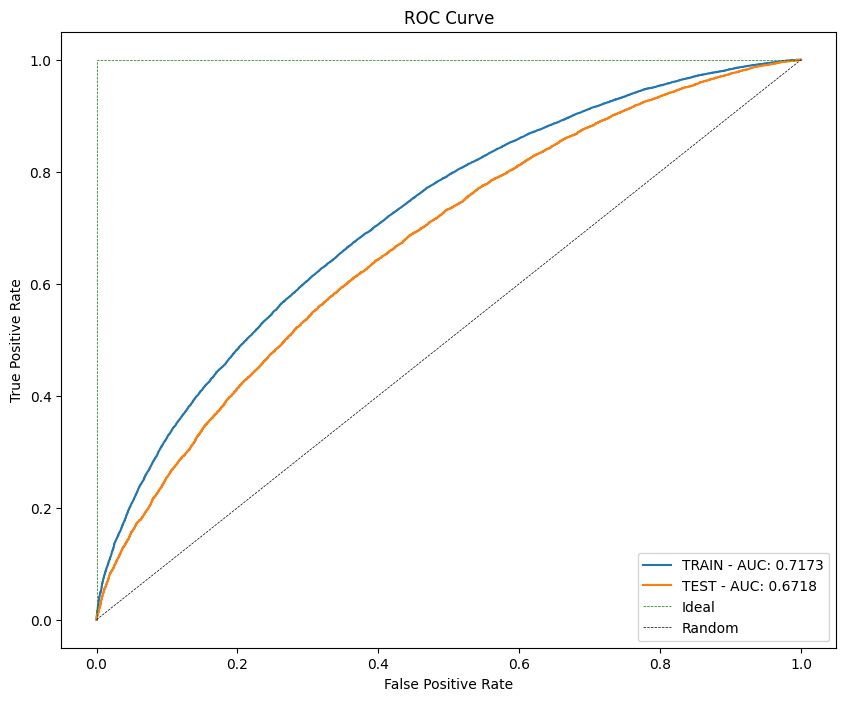

In [106]:
#Plot
plt.figure(figsize=[10,8])
plt.plot(fpr_train, tpr_train, label='TRAIN - AUC: {:.4f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='TEST - AUC: {:.4f}'.format(auc_test))
plt.title('ROC Curve')
plt.plot([0,0,1],[0,1,1], color='green', linestyle='--', linewidth=0.5, label='Ideal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=0.5, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Matrix Confusion

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [108]:
cm_test = confusion_matrix(y_test, y_test_pred)

[]

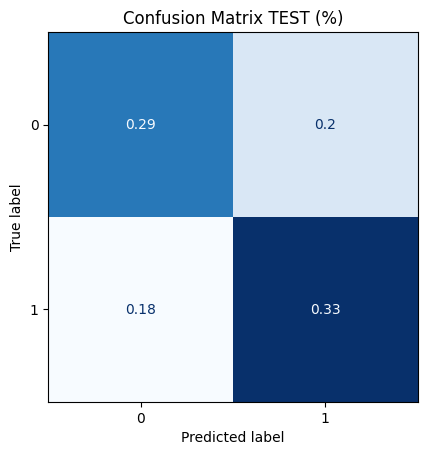

In [109]:
ConfusionMatrixDisplay(confusion_matrix=cm_test/len(y_test)).plot(colorbar = False, cmap = 'Blues')
plt.title('Confusion Matrix TEST (%)')
plt.plot()

- Accuracy, Precision, Recall y F1-Score

In [110]:
cm_test

array([[7455, 5175],
       [4576, 8566]])

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [112]:
print('Accuracy:', round( accuracy_score(y_test, y_test_pred),4))
print('Precision:', round( precision_score(y_test, y_test_pred), 4))
print('Recall:', round( recall_score(y_test, y_test_pred), 4))
print('F1-score:', round(f1_score(y_test, y_test_pred), 4))

Accuracy: 0.6216
Precision: 0.6234
Recall: 0.6518
F1-score: 0.6373


In [113]:
import shap

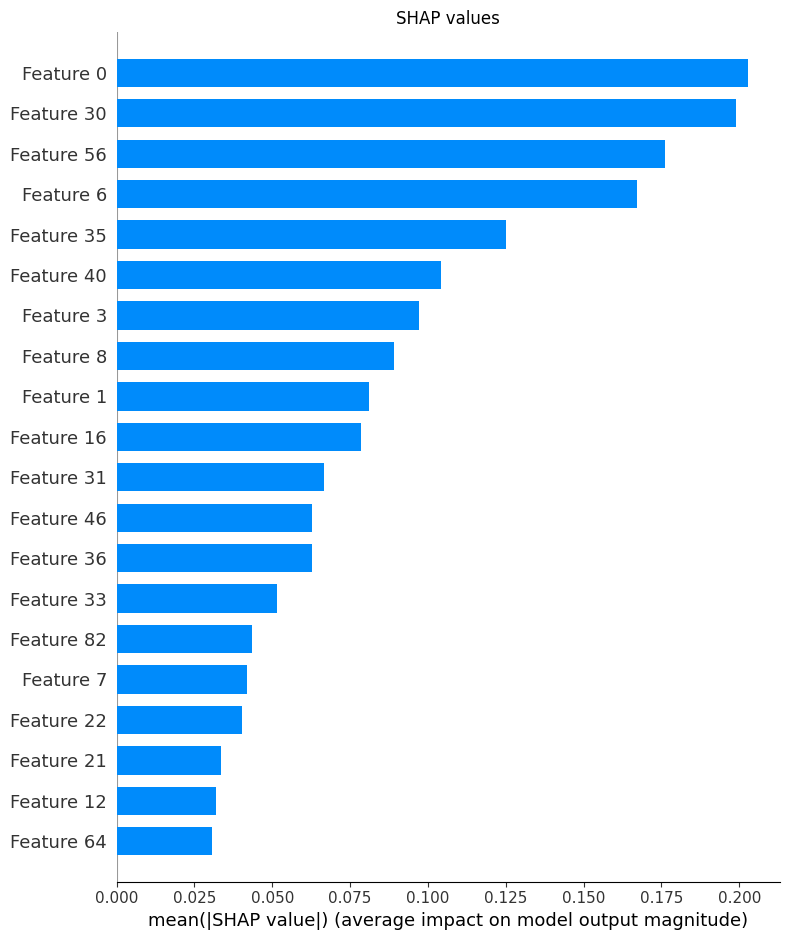

In [114]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

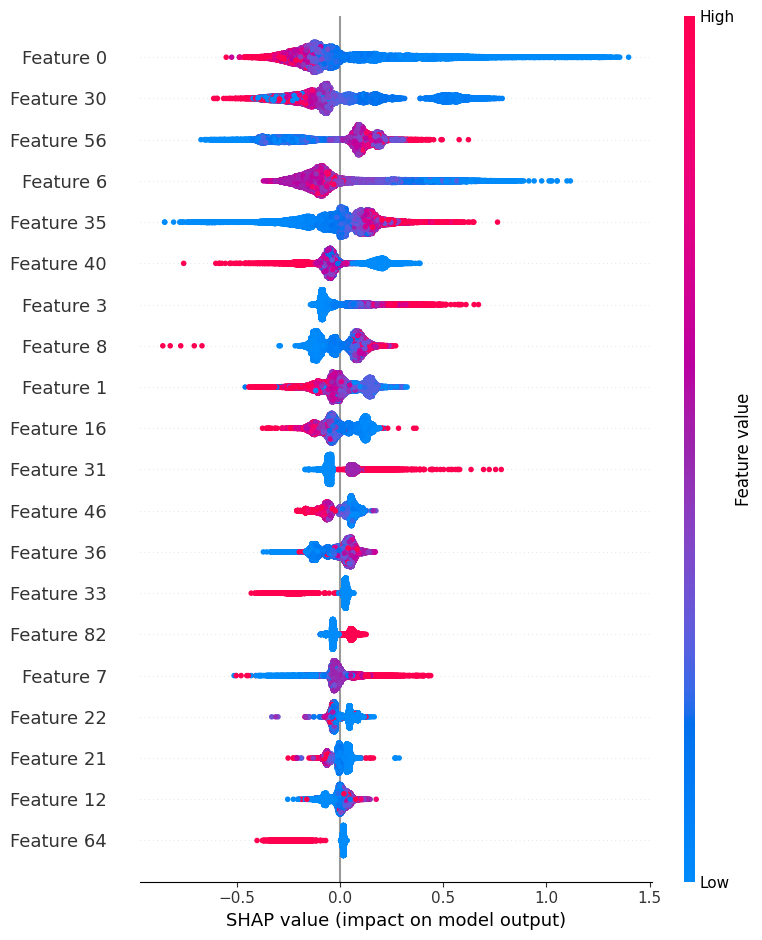

In [115]:
shap.summary_plot(shap_values, X_test)